# Imports

In [1]:
# stdlib
import re
import copy
import random
import itertools
import statistics
import multiprocessing

# data wrangling
import numpy as np
import pandas as pd
import statsmodels.api as sm

from scipy import stats
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# custom
from hotspot_classes import Hotspot
import hotspot_utils


# Set the number of processors to use for parallel processing
n_processors = max([1,multiprocessing.cpu_count()-2])

# Read in the insults list
with open('insults.txt', 'r') as f:
    insults = f.read().splitlines()

# Reading data - Works for single or double file layouts

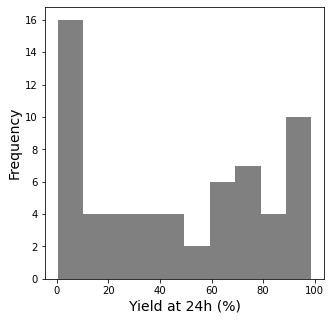

,Yield at 24h (%),#acid,#amide,#amidine,#amine,#in34,#in56,#metab,#NandO,#noncon,...,μ_Boltz,μ_low_E,μ_max,μ_min,μ_range,ω_Boltz,ω_low_E,ω_max,ω_min,ω_range
ID,,,,,,,,,,,,,,,,,,,,,
0,1.5,0,0,0,0,0,6,1,2,0,...,-0.186925,-0.186925,-0.186925,-0.186925,0.00000,0.05806,0.05806,0.05806,0.05806,0.0
6,23.1,0,0,0,0,0,6,0,2,0,...,-0.196085,-0.196085,-0.196085,-0.196085,0.00000,0.06608,0.06608,0.06608,0.06608,0.0
8,76.0,0,0,0,0,0,6,1,3,0,...,-0.206550,-0.206550,-0.206550,-0.206550,0.00000,0.06839,0.06839,0.06839,0.06839,0.0
11,62.9,0,0,0,0,0,6,0,2,0,...,-0.213520,-0.213520,-0.213520,-0.213520,0.00000,0.07568,0.07568,0.07568,0.07568,0.0
28,4.5,0,0,0,0,0,10,0,2,0,...,-0.178085,-0.178085,-0.178085,-0.178085,0.00000,0.06491,0.06491,0.06491,0.06491,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3410,61.1,0,0,0,0,0,9,1,3,0,...,-0.192180,-0.192180,-0.192180,-0.192180,0.00000,0.07300,0.07300,0.07300,0.07300,0.0
3422,2.1,0,0,0,0,0,6,0,4,0,...,-0.176370,-0.176375,-0.176365,-0.176375,0.00001,0.05685,0.05685,0.05685,0.05685,0.0
3780,26.6,0,0,0,0,0,5,1,2,0,...,-0.192040,-0.192040,-0.192040,-0.192040,0.00000,0.06870,0.06870,0.06870,0.06870,0.0


In [5]:
# This cell assumes that your spreadsheets are in .xlsx format and that there are no columns after the parameters
# or rows after the last reaction. Extra rows and columns before the data are fine and can be skipped with the
# vs_parameters_header_rows and vs_parameters_start_col variables.
# Check cell outputs to make sure everything looks good

parameters_file = "Sulfonyl_Fluoride_Yields" # Excel file to pull parameters from
parameters_sheet = "all_descriptors" # Sheet in the Excel file to pull parameters from
parameters_start_col = 6   # 0-indexed column number where the parameters start
parameters_y_label_col = 0  # 0-indexed column number where the ligand labels are
parameters_header_rows = 0 # Number of rows to skip when reading the parameters

response_file = "Sulfonyl_Fluoride_Yields" # Excel file to pull responses from
response_sheet = "all_descriptors" # Sheet in the Excel file to pull responses from
response_col = 4 # 0-indexed column number for the responses
response_y_label_col = 0  # 0-indexed column number where the ligand labels are
response_header_rows = 0 # Number of rows to skip when reading the responses

RESPONSE_LABEL = "Yield at 24h (%)" # Name of your response variable

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE
# --------------------------------------------------------------------------------------------------------------

# Actually start reading stuff into dataframes
parameters_df = pd.read_excel("./InputData/" + parameters_file + ".xlsx",
                              parameters_sheet,
                              header = parameters_header_rows,
                              index_col = parameters_y_label_col,
                              )
response_df = pd.read_excel("./InputData/" + response_file + ".xlsx",
                            response_sheet,
                            header = response_header_rows,
                            index_col = response_y_label_col,
                            usecols = list(range(0, response_col + 1))
                            )


# Drop any columns before parameters_start_col that are not the index column
parameters_columns_to_keep = [col for col in range(0, len(parameters_df.columns)) if col >= parameters_start_col-1]
parameters_df = parameters_df.iloc[:,parameters_columns_to_keep]

# Combine the two dataframes into the master dataframe
response_df.drop(response_df.columns[0:response_col-1], axis = 'columns', inplace = True)
data_df = response_df.merge(parameters_df, left_index = True, right_index = True)
data_df.rename(columns = {data_df.columns.values[0]: RESPONSE_LABEL}, inplace = True) # Converts the output column name from whatever it is on the spreadsheet
data_df.dropna(inplace = True) # Remove any rows with blanks

# This converts all the data to numeric values since it was reading them in as non-numeric objects for some reason
for column in data_df.columns:
    data_df[column] = pd.to_numeric(data_df[column], errors='coerce')

# Get a list of all the features
all_features = list(data_df.columns)
all_features.remove(RESPONSE_LABEL)

# Check for duplicate reaction labels or column names
error = False
if len(list(data_df.index)) != len(list(set(data_df.index))):
    print('THERE ARE DUPLICATE REACTION LABELS IN THE DATA. PLEASE CORRECT THIS IN YOUR SPREADSHEET.')
    error = True
if len(list(data_df.columns)) != len(list(set(data_df.columns))):
    print('THERE ARE DUPLICATE COLUMN NAMES IN THE DATA. PLEASE CORRECT THIS IN YOUR SPREADSHEET.')
    error = True

if not error:
    # Print out the data distribution of the response variable
    plt.figure(figsize=(5, 5))
    plt.hist(data_df[RESPONSE_LABEL], color='grey')
    plt.xlabel(RESPONSE_LABEL, fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.show()

    # Display the dataframe
    display(data_df)


# Threshold Analysis

## Train/Validation/Test split

Training Set: [93, 3876, 2220, 3397, 3040, 3015, 3405, 2923, 88, 766, 86, 8, 2790, 6, 3283, 2722, 3406, 3393, 3407, 2912, 3387, 3404, 1132, 56, 3780, 3388, 3400, 28, 1826, 3391, 3395, 3317, 2187, 11, 0, 3035, 29]
Validation Set: [3866, 3409, 3410, 2237, 3389, 3394, 1827, 3408, 66, 3392, 39, 1778]
Test Set: [1820, 255, 3402, 2869, 2141, 3036, 3422, 82, 2136, 1830, 3398, 51]

Training Set size: 37
Validation Set size: 12
Test Set size: 12

Training Set mean: 46.592
Validation Set mean: 45.808
Test Set mean: 46.842


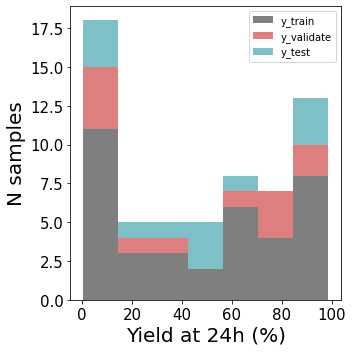

In [6]:
# Split options are 'random', 'ks', 'y_equidistant', 'stratified', 'define', 'none'

# Core options
split = "stratified"
validation_ratio = 0.2

# Test set options
use_test = True
test_ratio = 0.2

# Less common parameters
stratified_quantiles = 8 # Number of quantiles to split the data into for stratified sampling
defined_training_set = [] # If you want to manually define the training set, put the list of points here
defined_validation_set = [] # If you want to manually define the validation set, put the list of points here
defined_test_set = [] # If you want to manually define the test set, put the list of points here
randomstate = 42 # Random state for reproducibility

# If you get 'ValueError: The least populated class in y has only 1 member...', decrease the number of stratified_quantiles

# --------------------------------------------------------------------------------------------------------------

training_set, validation_set, test_set = hotspot_utils.train_test_splits(data_df, split, validation_ratio, test_ratio, all_features, RESPONSE_LABEL, use_test,
                                                        defined_test_set=defined_test_set, defined_training_set=defined_training_set, defined_validation_set=defined_validation_set,
                                                        randomstate=randomstate, stratified_quantiles=stratified_quantiles)

# For bookeeping purposes
if split == 'none':
    validation_ratio = 0
    test_ratio = 0

## Automatic Threshold Analysis

In [7]:
# Cutoff in your output for what counts as an active ligand
y_cut = 80

# Set to True if you want points below the y-cut to be considered active
low_is_good = False

# How heavily to value active ligands (1) over inactive ligands (0)
class_weight = {1:10, 0:1} 

# How the prune_hotspots and find_best_hotspots evaluates which are the best
# Can be set to 'accuracy', 'weighted_accuracy', 'f1', and 'weighted_f1'
evaluation_method = 'accuracy'

# How many threshold dimensions do you want?
n_thresholds = 2

# What percentage of thresholds are analyzed in each subsequent step
percentage = 100

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE
# --------------------------------------------------------------------------------------------------------------

# Set up y_class, the binary list of which y values are above y_cut
hotspot_data_df = copy.deepcopy(data_df)
hotspot_data_df['y_class'] = 0

if(low_is_good):
    for i in hotspot_data_df.index:
        hotspot_data_df.loc[i, 'y_class'] = int(hotspot_data_df.loc[i, RESPONSE_LABEL] < y_cut)
else:
    for i in hotspot_data_df.index:
        hotspot_data_df.loc[i, 'y_class'] = int(hotspot_data_df.loc[i, RESPONSE_LABEL] > y_cut)

# Find the best thresholds within the full X and y space and make single threshold hotspot objects from them
all_thresholds = hotspot_utils.threshold_generation(hotspot_data_df, class_weight, evaluation_method, all_features)
best_hotspots = []
for thresh in all_thresholds:
    temp_hs = Hotspot(hotspot_data_df, [thresh], y_cut, training_set, validation_set, evaluation_method, class_weight)
    best_hotspots.append(temp_hs)

# Cut down to the best {percentage} hotspots
best_hotspots = hotspot_utils.prune_hotspots(best_hotspots, percentage, evaluation_method)

# Add more thresholds, pruning after each step for resource management
for i in range(n_thresholds - 1):
    with multiprocessing.Pool(processes=int(n_processors-2)) as p:
        new_hotspots = p.starmap(hotspot_utils.hs_next_thresholds_fast, zip(best_hotspots, itertools.repeat(all_thresholds)))
    new_hotspots = [item for sublist in new_hotspots for item in sublist] 
    
    best_hotspots = hotspot_utils.prune_hotspots(new_hotspots, percentage, evaluation_method)

best_hotspots.sort(key = lambda x: x.accuracy_dict[evaluation_method], reverse = True)

# print the top 5 hotspots
for i, hs in enumerate(best_hotspots[:30]):
    print(f'Hotspot Index: {i}')
    print(hs)
    hs.print_stats()
    print('\n**********************************\n')

Hotspot Index: 0
Total accuracy with 2 thresholds: 0.918
Initial accuracy with no thresholds: 0.230
Total accuracy with 2 thresholds: 0.918
Initial accuracy with no thresholds: 0.230
Thresholds: 
	ChelpG_charge_F_max > -0.205 with Added accuracy of 0.557
	Sterimol_B1_S_F(Å)_morfeus_max < 2.078 with Added accuracy of 0.131

                    all    train  validation
         Accuracy: 0.918   0.892    1.000
Weighted Accuracy: 0.925   0.890    1.000
               F1: 0.839   0.800    1.000
      Weighted F1: 0.949   0.925    1.000

        Precision: 0.765   0.727    1.000
           Recall: 0.929   0.889    1.000


**********************************

Hotspot Index: 1
Total accuracy with 2 thresholds: 0.918
Initial accuracy with no thresholds: 0.230
Total accuracy with 2 thresholds: 0.918
Initial accuracy with no thresholds: 0.230
Thresholds: 
	ChelpG_charge_F_max > -0.205 with Added accuracy of 0.557
	Sterimol_L_S_F(Å)_morfeus_Boltz < 3.495 with Added accuracy of 0.131

             

## Visualize Thresholds

Total accuracy with 2 thresholds: 0.918
Initial accuracy with no thresholds: 0.230
Total accuracy with 2 thresholds: 0.918
Initial accuracy with no thresholds: 0.230
Thresholds: 
	dipole(Debye)_max < 5.877 with Added accuracy of 0.393
	pyramidalization_Gavrish_S(°)_max < 4.953 with Added accuracy of 0.295



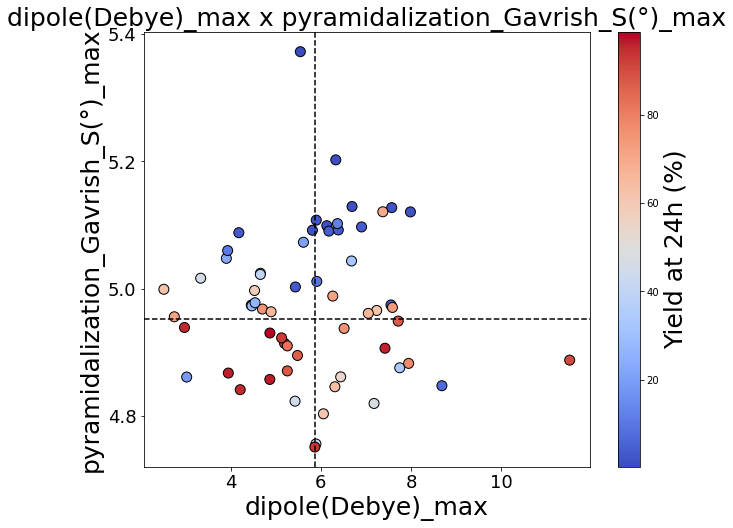

In [8]:
# For more direct control over plot style, changes can be made to the plotting functions in hotsput_utils.py
# One of the above functions must be run before this cell can ran
hotspot_index =  25
print(best_hotspots[hotspot_index])

# subset can be 'all', 'training', or 'test'
# You can change the coloring to either 'scaled' or 'binary'
hotspot_utils.plot_hotspot(best_hotspots[hotspot_index], 
                            subset='all', 
                            coloring='scaled', 
                            output_label=RESPONSE_LABEL, 
                            gradient_color='coolwarm')

## Threshold External Test Set Prediction

If this isn't the final step of your modeling process then this is just another validation set and not a true test set

                    all    train  validation
         Accuracy: 0.918   0.946    0.917
Weighted Accuracy: 0.829   0.907    0.667
               F1: 0.815   0.889    0.667
      Weighted F1: 0.873   0.936    0.667

        Precision: 0.846   0.889    1.000
           Recall: 0.786   0.889    0.500

External Test Stats:
Accuracy: 0.83
Weighted Accuracy: 0.72
Precision: 0.67
Recall: 0.67


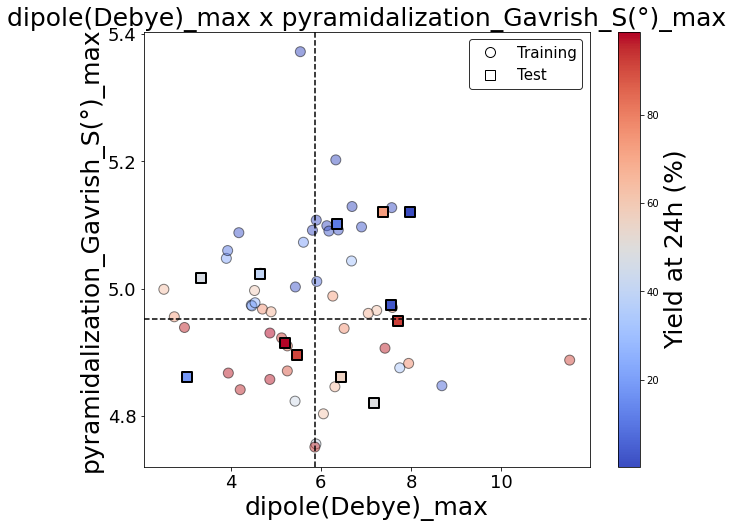

,dipole(Debye)_max,pyramidalization_Gavrish_S(°)_max
ID,,
1820,False,False
255,True,True
3402,False,False
2869,True,False
2141,True,False
3036,True,True
3422,False,False
82,False,True
2136,True,True


In [9]:
# Select hotspot to test
hotspot_index = 25

# Set to True if you want to see only the test results plotted
hide_training = False

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE UNLESS YOU WANT TO CHANGE THE PLOTTING DETAILS IN hotspot_utils.plot_hotspot(...)
# --------------------------------------------------------------------------------------------------------------

hs = best_hotspots[hotspot_index]
test_df = data_df.loc[test_set]

# Evaluate each validation point on each threshold
threshold_evaluations = hs.expand(test_df)

# Print the hotspot stats
hs.print_stats()

# Get validation stats and display the hotspot
print("External Test Stats:")
hs.get_external_accuracy(test_df, RESPONSE_LABEL, verbose=True)
hotspot_utils.plot_hotspot(hs, test_df, test_df, coloring='scaled', output_label=RESPONSE_LABEL, gradient_color='coolwarm', hide_training=hide_training)

# Display the threshold evaluations
# True means the point is in on the active side of that threshold
display(threshold_evaluations)